In [ ]:
# Import Dataset
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from keras.applications.xception import preprocess_input
from sklearn.metrics import confusion_matrix
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Location Path
train_path  = 'drive/My Drive/data pekalongan/train'
valid_path  = 'drive/My Drive/data pekalongan/valid'
test_path  = 'drive/My Drive/data pekalongan/test'

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    rescale=1./127.5-1.,
)

# Train, Test, Validation
train_batches = datagen.flow_from_directory(
    train_path, target_size=(299,299), batch_size=10)
valid_batches = datagen.flow_from_directory(
    valid_path, target_size=(299,299), batch_size=15)
test_batches = datagen.flow_from_directory(
    test_path, target_size=(299,299), batch_size=40)

Found 1834 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


In [ ]:
from collections import Counter

samples = Counter(train_batches.classes)

print(samples.items()) # dict_items([(0, 1648), (1, 3614)])

training_examples = 0;
for item in samples.items():
    training_examples += item[1]

print(training_examples)

dict_items([(0, 456), (1, 460), (2, 460), (3, 458)])
1834


In [ ]:
def entry_flow(inputs):

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for size in [128, 256, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(  # Project residual
        size, 1, strides=2, padding='same')(previous_block_activation)           
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  return x


def middle_flow(x, num_blocks=8):
  
  previous_block_activation = x

  for _ in range(num_blocks):
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, previous_block_activation])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    
  return x


def exit_flow(x, num_classes=1000):
  
  previous_block_activation = x

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.SeparableConv2D(1536, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.SeparableConv2D(2048, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  return layers.Dense(num_classes, activation=activation)(x)

In [ ]:
keras.backend.clear_session()

# Create Xception by chaining the 3 flows
inputs = keras.Input(shape=(299, 299, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs), num_blocks=8), num_classes=4)
xception = keras.Model(inputs, outputs)

In [ ]:
# Custom Early Stopping
# Expected behavior: EarlyStopping should restore weights on end of training regardless it stop training early or after the last epoch

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_val_loss = np.Inf
        self.best_loss = np.Inf
        self.best_val_accuracy = 0.0
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs.get('val_loss')
        loss = logs.get('loss')
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        # if np.less(val_loss, self.best_val_loss) and np.greater(map10, self.best_map10):
        if np.greater_equal(val_accuracy, self.best_val_accuracy) and np.greater_equal(accuracy, self.best_accuracy) and np.greater_equal(accuracy, val_accuracy):
            self.best_val_loss = val_loss
            self.best_loss = loss
            self.best_val_accuracy = val_accuracy
            self.best_accuracy = accuracy
            self.wait = 0

            # Record the best weights if current results is better.
            print("Saving the best weight at epoch {}".format(epoch + 1))
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Training stop early. Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        # EarlyStopping will restore weights after the last epoch only if it is not stop early
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch + 1))
        else:
            print("Training stop after the last epoch. Restoring model weights from the end of the best epoch.")
            self.model.set_weights(self.best_weights)

In [ ]:
xception.compile(RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callback to save the current best model
epochs = 50
patience = epochs

my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1, restore_best_weights=True),
    CustomEarlyStopping(patience=patience),
    #tf.keras.callbacks.ModelCheckpoint(filepath='batik-recognition-model.{epoch:03d}.hdf5',  monitor='val_accuracy', mode='max', verbose=0, save_best_only=False),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# Using Batch Gradient Descent (batch_size = training_examples) because data is less than 2000
# Stochastic Gradient Descent (batch_size = 1)
# Mini-Batch Gradient Descent (batch_size = 1 < number_power_of_2 < training_examples)
# steps per epoch = 18
# validation steps = 3
history = xception.fit(train_batches, 
                        steps_per_epoch=4, 
                        batch_size=training_examples, 
                        validation_data=valid_batches, 
                        validation_steps=2, 
                        epochs=epochs, verbose=2, 
                        callbacks=my_callbacks, 
                        shuffle=True)

Epoch 1/50
4/4 - 106s - loss: 16.2980 - accuracy: 0.2500 - val_loss: 9123589120.0000 - val_accuracy: 0.3000 - 106s/epoch - 27s/step
Epoch 2/50
Saving the best weight at epoch 2
4/4 - 84s - loss: 7.2532 - accuracy: 0.2750 - val_loss: 37185096.0000 - val_accuracy: 0.2667 - 84s/epoch - 21s/step
Epoch 3/50
4/4 - 82s - loss: 3.7886 - accuracy: 0.2750 - val_loss: 14192149.0000 - val_accuracy: 0.2000 - 82s/epoch - 20s/step
Epoch 4/50
4/4 - 77s - loss: 5.8166 - accuracy: 0.1750 - val_loss: 1318.6537 - val_accuracy: 0.2333 - 77s/epoch - 19s/step
Epoch 5/50
4/4 - 82s - loss: 2.4621 - accuracy: 0.2250 - val_loss: 17.3250 - val_accuracy: 0.2333 - 82s/epoch - 20s/step
Epoch 6/50
Saving the best weight at epoch 6
4/4 - 84s - loss: 2.0525 - accuracy: 0.4000 - val_loss: 1.9899 - val_accuracy: 0.3667 - 84s/epoch - 21s/step
Epoch 7/50
4/4 - 85s - loss: 4.9729 - accuracy: 0.2750 - val_loss: 29720082.0000 - val_accuracy: 0.1000 - 85s/epoch - 21s/step
Epoch 8/50
4/4 - 83s - loss: 3.2558 - accuracy: 0.2500 

In [ ]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [ ]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset(test_path)

In [ ]:
from keras.preprocessing import image  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 160/160 [00:01<00:00, 108.60it/s]


In [ ]:
# Model Testing
# if you want to select the model yourself, uncomment the next line and change the filename as the one you choose
# new_model.load_weights('filename.hdf5')

print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*xception.evaluate(test_tensors, test_targets)))

5/5 [==============================] - 61s 12s/step - loss: 44.9677 - accuracy: 0.2250

Testing loss: 44.9677
Testing accuracy: 0.2250


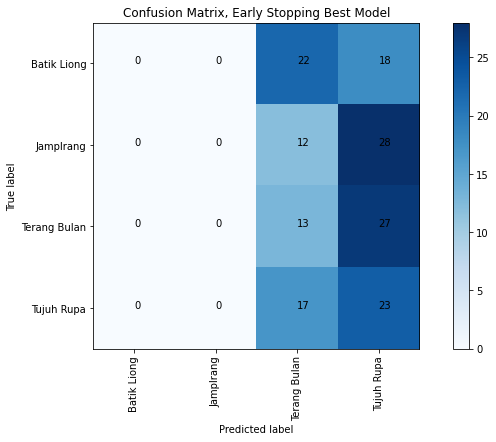

In [ ]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix

cm_labels = ['Batik Liong','Jamplrang', 'Terang Bulan', 'Tujuh Rupa']

y_true = np.argmax(test_targets, axis=1)
y_pred = np.argmax(xception.predict(test_tensors), axis=1)

plt.figure(figsize=(12, 6))
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion Matrix, Early Stopping Best Model')
plt.show()

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_targets, axis=1), np.argmax(xception.predict(test_tensors), axis=1), target_names=cm_labels))

              precision    recall  f1-score   support

 Batik Liong       0.00      0.00      0.00        40
   Jamplrang       0.00      0.00      0.00        40
Terang Bulan       0.20      0.33      0.25        40
  Tujuh Rupa       0.24      0.57      0.34        40

    accuracy                           0.23       160
   macro avg       0.11      0.22      0.15       160
weighted avg       0.11      0.23      0.15       160



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Geometric Mean
from imblearn.metrics import geometric_mean_score
geometric_mean_score(y_true, y_pred, pos_label=1, average=None, correction=0.0)

array([0.        , 0.        , 0.43229041, 0.4745612 ])

===============================================================================================================

In [ ]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import xception

base_model = xception.Xception(weights=None, include_top=False, input_shape = (299,299, 3), pooling='avg') # don't include Xception classifier part
print("The length of feature extraction layers of Xception is ", len(base_model.layers))

last_layer = base_model.get_layer('block14_sepconv2_act')
last_output = last_layer.output

# add your own classification layer
x = Flatten()(last_output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(4, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
xception2 = Model(inputs=base_model.input, outputs=x)

sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True, decay=1e-2/epochs)

xception2.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])

The length of feature extraction layers of Xception is  133


In [ ]:
history = xception2.fit(train_batches, 
                        steps_per_epoch=4, 
                        batch_size=training_examples, 
                        validation_data=valid_batches, 
                        validation_steps=2, 
                        epochs=epochs, verbose=2, 
                        callbacks=my_callbacks, 
                        shuffle=True)

In [ ]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*xception2.evaluate(test_tensors, test_targets)))

In [ ]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix

cm_labels = ['Batik Liong','Jamplrang', 'Terang Bulan', 'Tujuh Rupa']

y_true = np.argmax(test_targets, axis=1)
y_pred = np.argmax(xception2.predict(test_tensors), axis=1)

plt.figure(figsize=(12, 6))
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion Matrix, Early Stopping Best Model')
plt.show()

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_targets, axis=1), np.argmax(xception2.predict(test_tensors), axis=1), target_names=cm_labels))

In [ ]:
# Geometric Mean
from imblearn.metrics import geometric_mean_score
geometric_mean_score(y_true, y_pred, pos_label=1, average=None, correction=0.0)